In [11]:
from preprocessing.utils import join_dataframes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

**Objective**:

Examine how price the customer spent, the recency (time since last shopping) and the reviews left are correlated. Can we observe some regularities?

In [12]:
order_payments_dataset_done = pd.read_csv('./data/processed/order_payments_dataset_done.csv', index_col=0)
order_reviews_dataset_done = pd.read_csv('./data/processed/order_reviews_dataset_done.csv', index_col=0)
orders_dataset_done = pd.read_csv('./data/processed/orders_dataset_done.csv', index_col=0)

In [13]:
order_payments_dataset = order_payments_dataset_done.copy()
orders_dataset = orders_dataset_done.copy()
order_reviews_dataset = order_reviews_dataset_done.copy()

In [14]:
order_payments_dataset = order_payments_dataset.groupby('order_id').agg(monetary_value=('payment_value', 'sum')).reset_index()

In [15]:
orders_dataset['order_purchase_timestamp'] = orders_dataset['order_purchase_timestamp'].astype('datetime64[ns]')

In [16]:
max_purchase_date = orders_dataset["order_purchase_timestamp"].max()
max_purchase_date

Timestamp('2018-08-29 15:00:37')

In [17]:
# Column Recency indicates the days elapsed between purchasing the latest product
orders_dataset["recency"] = (max_purchase_date - orders_dataset["order_purchase_timestamp"]).dt.days

In [18]:
orders_dataset = orders_dataset[["order_id", "recency"]]
orders_dataset

,order_id,recency
0,e481f51cbdc54678b7cc49136f2d6af7,331
1,53cdb2fc8bc7dce0b6741e2150273451,35
2,47770eb9100c2d0c44946d9cf07ec65d,21
3,949d5b44dbf5de918fe9c16f97b45f8a,283
4,ad21c59c0840e6cb83a9ceb5573f8159,196
...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,538
99437,63943bddc261676b46f01ca7ac2f7bd8,204
99438,83c1379a015df1e13d02aae0204711ab,367
99439,11c177c8e97725db2631073c19f07b62,232


In [19]:
order_reviews_dataset = order_reviews_dataset_done[["order_id", "review_score_extended"]].groupby('order_id') \
                            .agg(review_score_extended=('review_score_extended', 'mean')).reset_index()
order_reviews_dataset

,order_id,review_score_extended
0,00010242fe8c5a6d1ba2dd792cb16214,6.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,6.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,6.0
...,...,...
92420,fffc94f6ce00a00581880bf54a75a037,5.0
92421,fffcd46ef2263f404302a634eb57f7eb,5.0
92422,fffce4705a9662cd70adb13d4a31832d,5.0
92423,fffe18544ffabc95dfada21779c9644f,6.0


In [20]:
first_join = join_dataframes([order_payments_dataset, orders_dataset],
                [{"order_id": "order_id"}, {"order_id": "order_id"}])
first_join

,order_id,monetary_value_0,recency_1
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,350.0
1,00018f77f2f0320c557190d7a144bdd3,259.83,490.0
2,000229ec398224ef6ca0657da4fc703e,216.87,227.0
3,00024acbcdf0a6daa1e931b038114c75,25.78,21.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,571.0
...,...,...,...
98273,fffbee3b5462987e66fb49b1c5411df2,139.88,71.0
98274,fffc94f6ce00a00581880bf54a75a037,343.40,128.0
98276,fffce4705a9662cd70adb13d4a31832d,116.85,309.0
98277,fffe18544ffabc95dfada21779c9644f,64.71,379.0


In [21]:
all_joined = join_dataframes([first_join, order_reviews_dataset],
                              [{"order_id": "order_id"}, {"order_id": "order_id"}])
all_joined

,order_id,monetary_value_0_0,recency_1_0,review_score_extended_1
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,350.0,6.0
1,00018f77f2f0320c557190d7a144bdd3,259.83,490.0,4.0
2,000229ec398224ef6ca0657da4fc703e,216.87,227.0,6.0
3,00024acbcdf0a6daa1e931b038114c75,25.78,21.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,571.0,6.0
...,...,...,...,...
97848,fffbee3b5462987e66fb49b1c5411df2,139.88,71.0,5.0
97849,fffc94f6ce00a00581880bf54a75a037,343.40,128.0,5.0
97851,fffce4705a9662cd70adb13d4a31832d,116.85,309.0,5.0
97852,fffe18544ffabc95dfada21779c9644f,64.71,379.0,6.0


In [22]:
all_joined.reset_index(drop=True)

,order_id,monetary_value_0_0,recency_1_0,review_score_extended_1
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,350.0,6.0
1,00018f77f2f0320c557190d7a144bdd3,259.83,490.0,4.0
2,000229ec398224ef6ca0657da4fc703e,216.87,227.0,6.0
3,00024acbcdf0a6daa1e931b038114c75,25.78,21.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,571.0,6.0
...,...,...,...,...
77159,fffbee3b5462987e66fb49b1c5411df2,139.88,71.0,5.0
77160,fffc94f6ce00a00581880bf54a75a037,343.40,128.0,5.0
77161,fffce4705a9662cd70adb13d4a31832d,116.85,309.0,5.0
77162,fffe18544ffabc95dfada21779c9644f,64.71,379.0,6.0


In [23]:
all_joined.rename(columns={"monetary_value_0_0": "MonetaryValue",
                           "recency_1_0": "Recency",
                           "review_score_extended_1": "ReviewScore"}, inplace=True)

In [24]:
# 77 164 rows
all_joined

,order_id,MonetaryValue,Recency,ReviewScore
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,350.0,6.0
1,00018f77f2f0320c557190d7a144bdd3,259.83,490.0,4.0
2,000229ec398224ef6ca0657da4fc703e,216.87,227.0,6.0
3,00024acbcdf0a6daa1e931b038114c75,25.78,21.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,571.0,6.0
...,...,...,...,...
97848,fffbee3b5462987e66fb49b1c5411df2,139.88,71.0,5.0
97849,fffc94f6ce00a00581880bf54a75a037,343.40,128.0,5.0
97851,fffce4705a9662cd70adb13d4a31832d,116.85,309.0,5.0
97852,fffe18544ffabc95dfada21779c9644f,64.71,379.0,6.0


In [25]:
all_joined.describe().T

,count,mean,std,min,25%,50%,75%,max
MonetaryValue,77164.0,113.773051,72.178801,6.84,57.82,95.67,153.5025,1338.41
Recency,77164.0,237.054987,151.804198,0.00,113.00,220.00,350.0000,695.00
ReviewScore,77164.0,4.437473,1.509316,0.00,4.00,5.00,5.0000,6.00


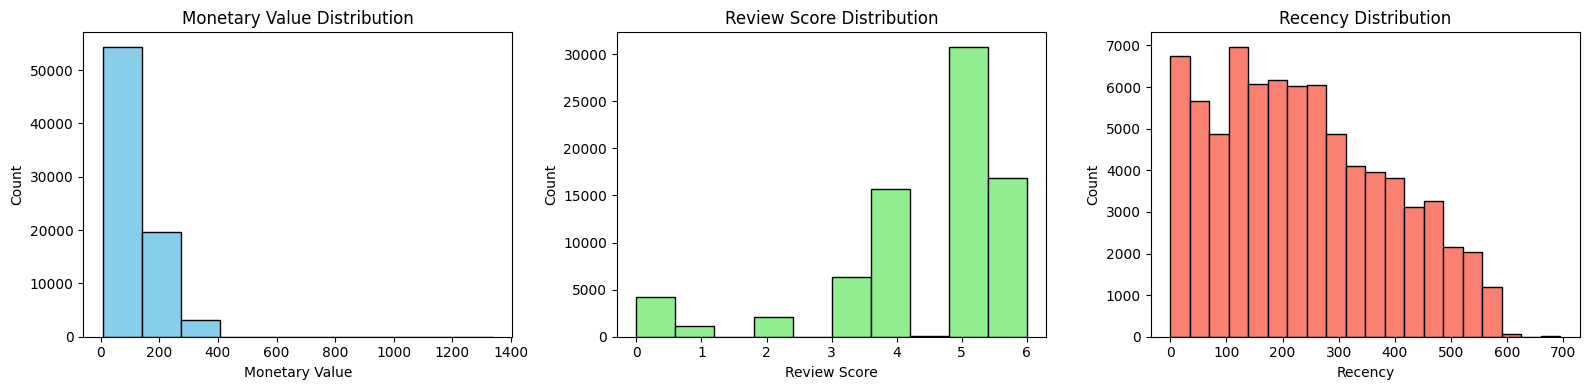

In [26]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.hist(all_joined['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(all_joined['ReviewScore'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(all_joined['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

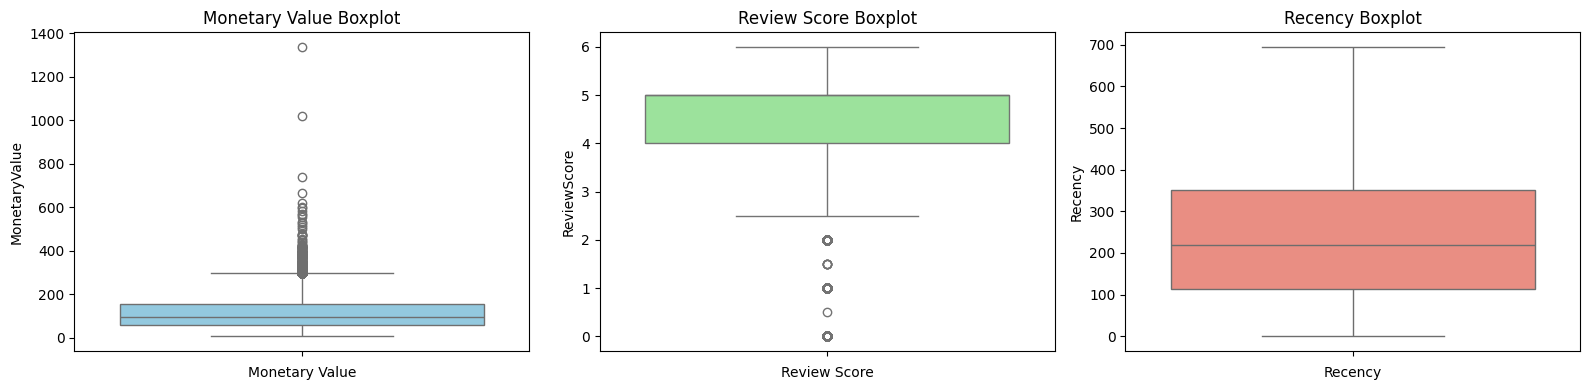

In [27]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=all_joined['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=all_joined['ReviewScore'], color='lightgreen')
plt.title('Review Score Boxplot')
plt.xlabel('Review Score')

plt.subplot(1, 3, 3)
sns.boxplot(data=all_joined['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [28]:
# Create new cluster for outlier values in MonetaryValue
M_Q1 = all_joined["MonetaryValue"].quantile(0.25)
M_Q3 = all_joined["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = all_joined[(all_joined["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (all_joined["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()
monetary_outliers_df.describe()[["MonetaryValue"]]

,MonetaryValue
count,2069.000000
mean,325.020614
std,39.909271
min,297.070000
25%,309.620000
50%,319.110000
75%,333.430000
max,1338.410000


In [29]:
monetary_outliers_df

,order_id,MonetaryValue,Recency,ReviewScore
26,0011d82c4b53e22e84023405fb467e57,315.33,224.0,4.0
164,0078a358a14592b887eb140ef515f5ab,336.38,295.0,6.0
199,0094d4660e323945f84f5c29eb348aae,309.40,216.0,5.0
226,00a57dfbb049fbaae10763e2cf15f797,337.38,40.0,5.0
276,00c00d5b36157595e21108ba1da2828f,312.92,351.0,1.0
...,...,...,...,...
97613,ff4cdf9a24ffba79c88c81aeb858b4c7,303.86,384.0,5.0
97745,ffb2c3a5bb149a2f860e5d057096201f,311.88,117.0,5.0
97798,ffdc5e3279114c523a09296f8fd28331,317.79,565.0,4.0
97804,ffde92ba447b33a47d1c04d203f10f41,304.70,278.0,5.0


In [30]:
# Filtering out outlies from MonetaryValue
non_outliers_df = all_joined[(~all_joined.index.isin(monetary_outliers_df.index))]
non_outliers_df.describe()  # no outliers in MonetaryValue

,MonetaryValue,Recency,ReviewScore
count,75095.000000,75095.000000,75095.000000
mean,107.952807,236.915813,4.440005
std,63.608593,151.788515,1.505649
min,6.840000,0.000000,0.000000
25%,57.170000,113.000000,4.000000
50%,93.130000,220.000000,5.000000
75%,147.260000,350.000000,5.000000
max,297.020000,695.000000,6.000000


Now $max(MonetaryValue) = 297$ instead of about $1400$.

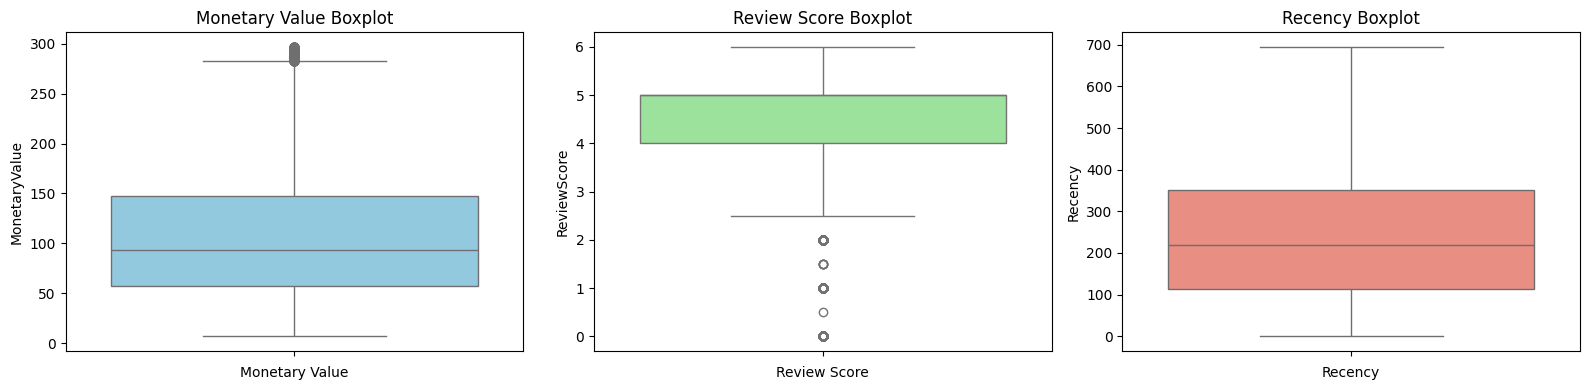

In [31]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['ReviewScore'], color='lightgreen')
plt.title('Review Score Boxplot')
plt.xlabel('Review Score')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

Looking better in MonetaryValue.

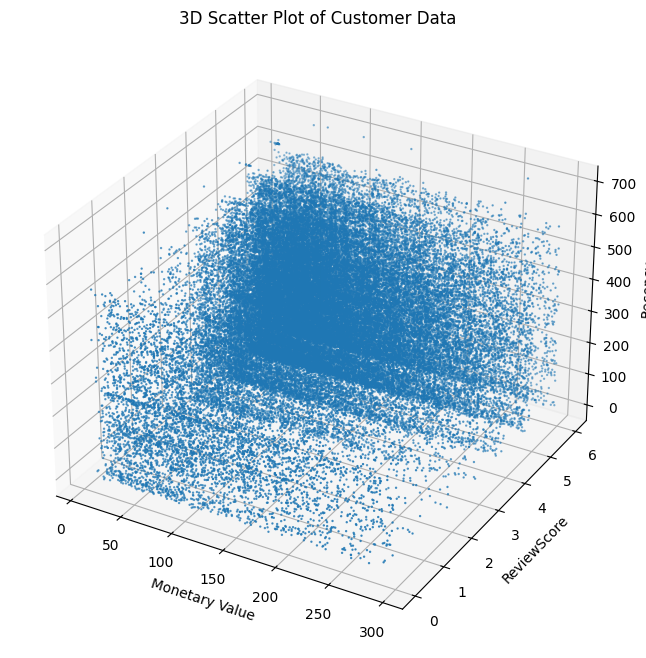

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"],
                     non_outliers_df["ReviewScore"],
                     non_outliers_df["Recency"], s=0.5)

ax.set_xlabel('Monetary Value')
ax.set_ylabel('ReviewScore')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

In [33]:
scaler = StandardScaler()

scaled_nparray = scaler.fit_transform(non_outliers_df[["MonetaryValue", "ReviewScore", "Recency"]])
scaled_nparray

array([[-0.56223607,  1.03610148,  0.74501644],
       [ 2.38769949, -0.29223791,  1.6673585 ],
       [ 1.71231454,  1.03610148, -0.06532694],
       ...,
       [ 0.13987501,  0.37193178,  0.47490198],
       [-0.67983103,  1.03610148,  0.93607301],
       [-0.82006459,  0.37193178, -1.03378611]])

In [34]:
scaled_df = pd.DataFrame(scaled_nparray, 
                         index=non_outliers_df.index, 
                         columns=["MonetaryValue", "ReviewScore", "Recency"])
scaled_df

,MonetaryValue,ReviewScore,Recency
0,-0.562236,1.036101,0.745016
1,2.387699,-0.292238,1.667359
2,1.712315,1.036101,-0.065327
3,-1.291859,-0.292238,-1.422487
4,1.730708,1.036101,2.200999
...,...,...,...
97846,-1.068932,0.371932,-0.566027
97848,0.501935,0.371932,-1.093080
97851,0.139875,0.371932,0.474902
97852,-0.679831,1.036101,0.936073


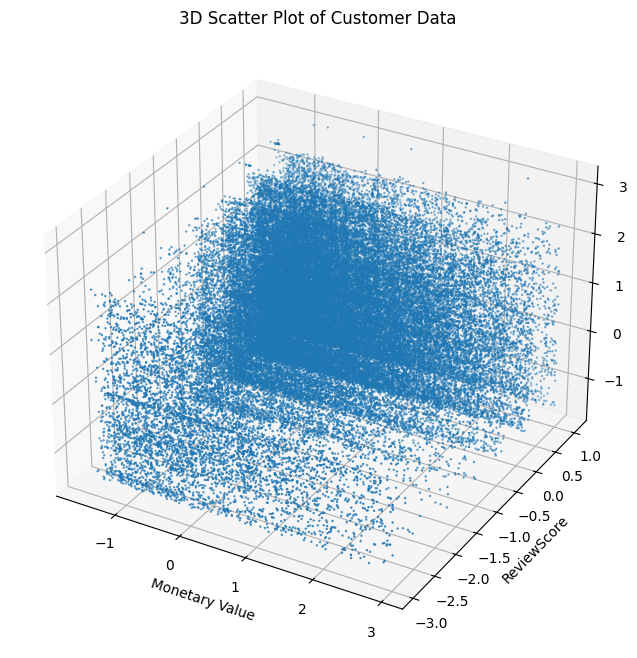

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_df["MonetaryValue"],
                     scaled_df["ReviewScore"],
                     scaled_df["Recency"], s=0.5)

ax.set_xlabel('Monetary Value')
ax.set_ylabel('ReviewScore')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

### KMeans

Very explainable

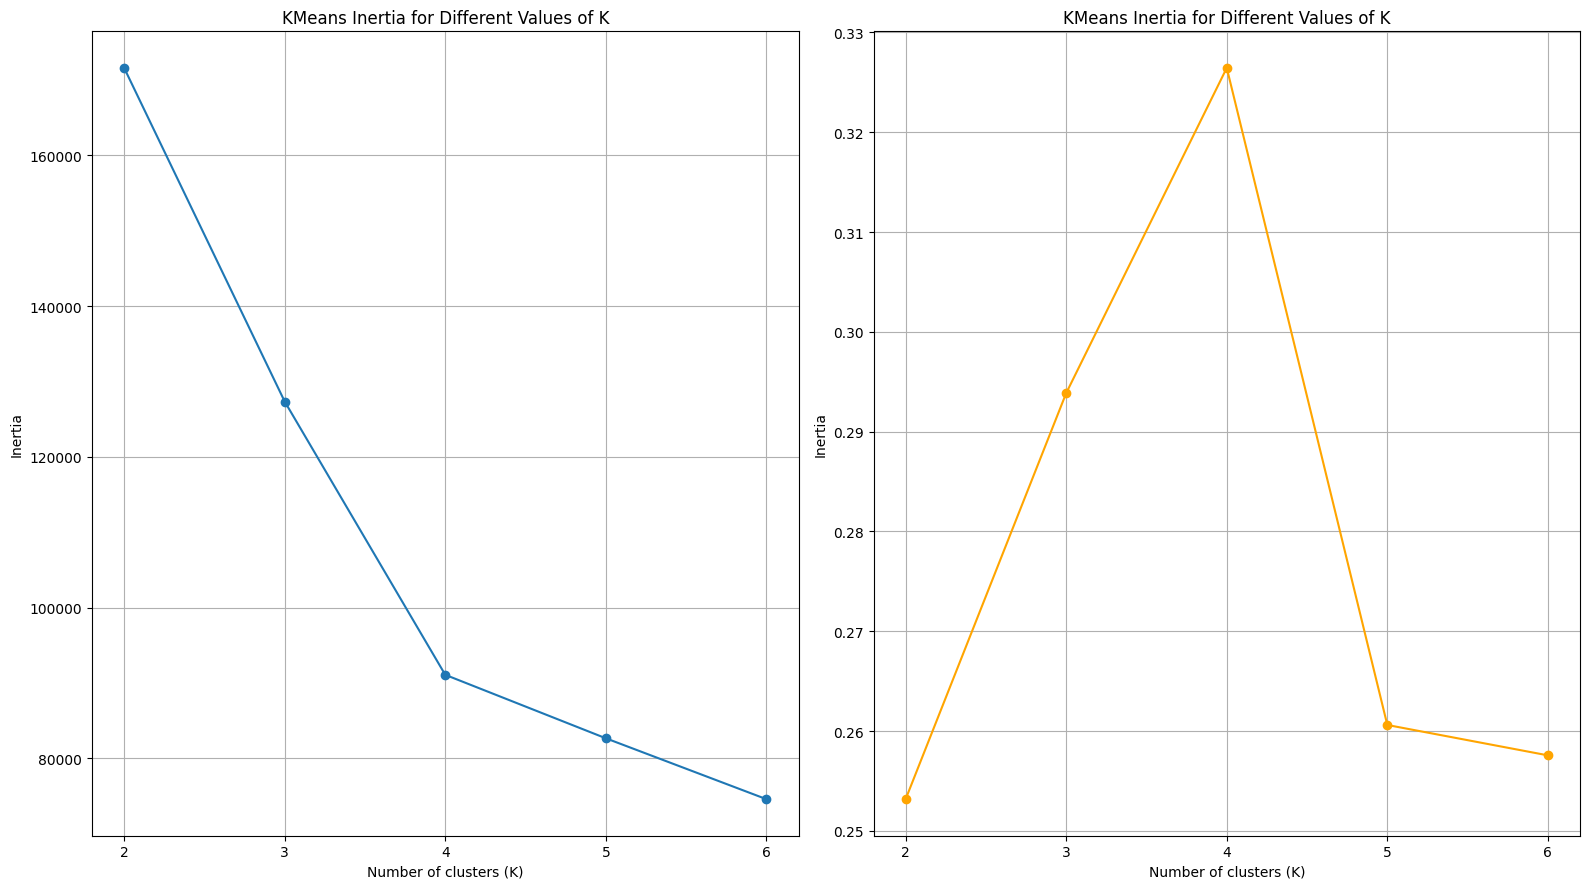

In [36]:
max_k = 6  # upper limit of K

inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_df)
    sil_scr = silhouette_score(scaled_df, cluster_labels)
    inertia.append(kmeans.inertia_)  # avg distance between centroids and data points in each cluster
    silhouette_scores.append(sil_scr)
    
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('KMeans Inertia for Different Values of K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_df)
cluster_labels

array([0, 2, 2, ..., 0, 0, 1])

In [38]:
# Adding the column with predictions
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

C:\Users\jk200\AppData\Local\Temp\ipykernel_14968\1621505023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,order_id,MonetaryValue,Recency,ReviewScore,Cluster
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,350.0,6.0,0
1,00018f77f2f0320c557190d7a144bdd3,259.83,490.0,4.0,2
2,000229ec398224ef6ca0657da4fc703e,216.87,227.0,6.0,2
3,00024acbcdf0a6daa1e931b038114c75,25.78,21.0,4.0,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,571.0,6.0,2
...,...,...,...,...,...
97846,fffb2ef8874127f75b52b643880fd7e0,39.96,151.0,5.0,1
97848,fffbee3b5462987e66fb49b1c5411df2,139.88,71.0,5.0,1
97851,fffce4705a9662cd70adb13d4a31832d,116.85,309.0,5.0,0
97852,fffe18544ffabc95dfada21779c9644f,64.71,379.0,6.0,0


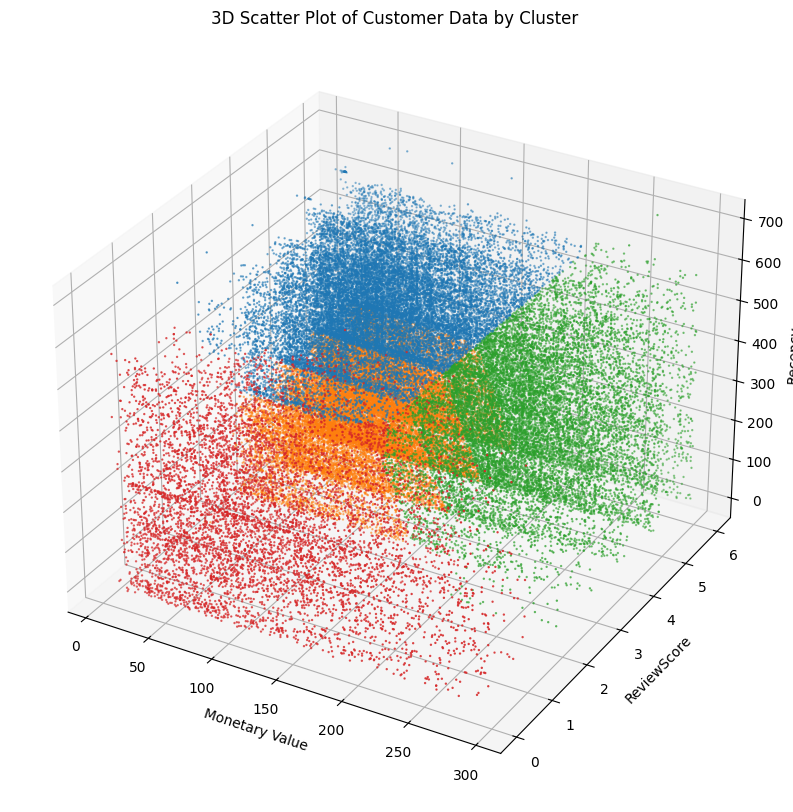

In [39]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors) # Series with changed numbers to colors

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['ReviewScore'], 
                     non_outliers_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o',
                     s=0.5)

ax.set_xlabel('Monetary Value')
ax.set_ylabel('ReviewScore')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

### Quick sum-up

**Blue**:
- High Recency, high Review Score, Low Monetary Value

**Orange**:
- Low Recency, high Review Score, Low Monetary Value

**Green**:
- Whole span of Recency, High & moderate Review Score, *Low* Monetary Value

**Red**:
- Whole span of Recency, low Review Score, whole span of Monetary Value

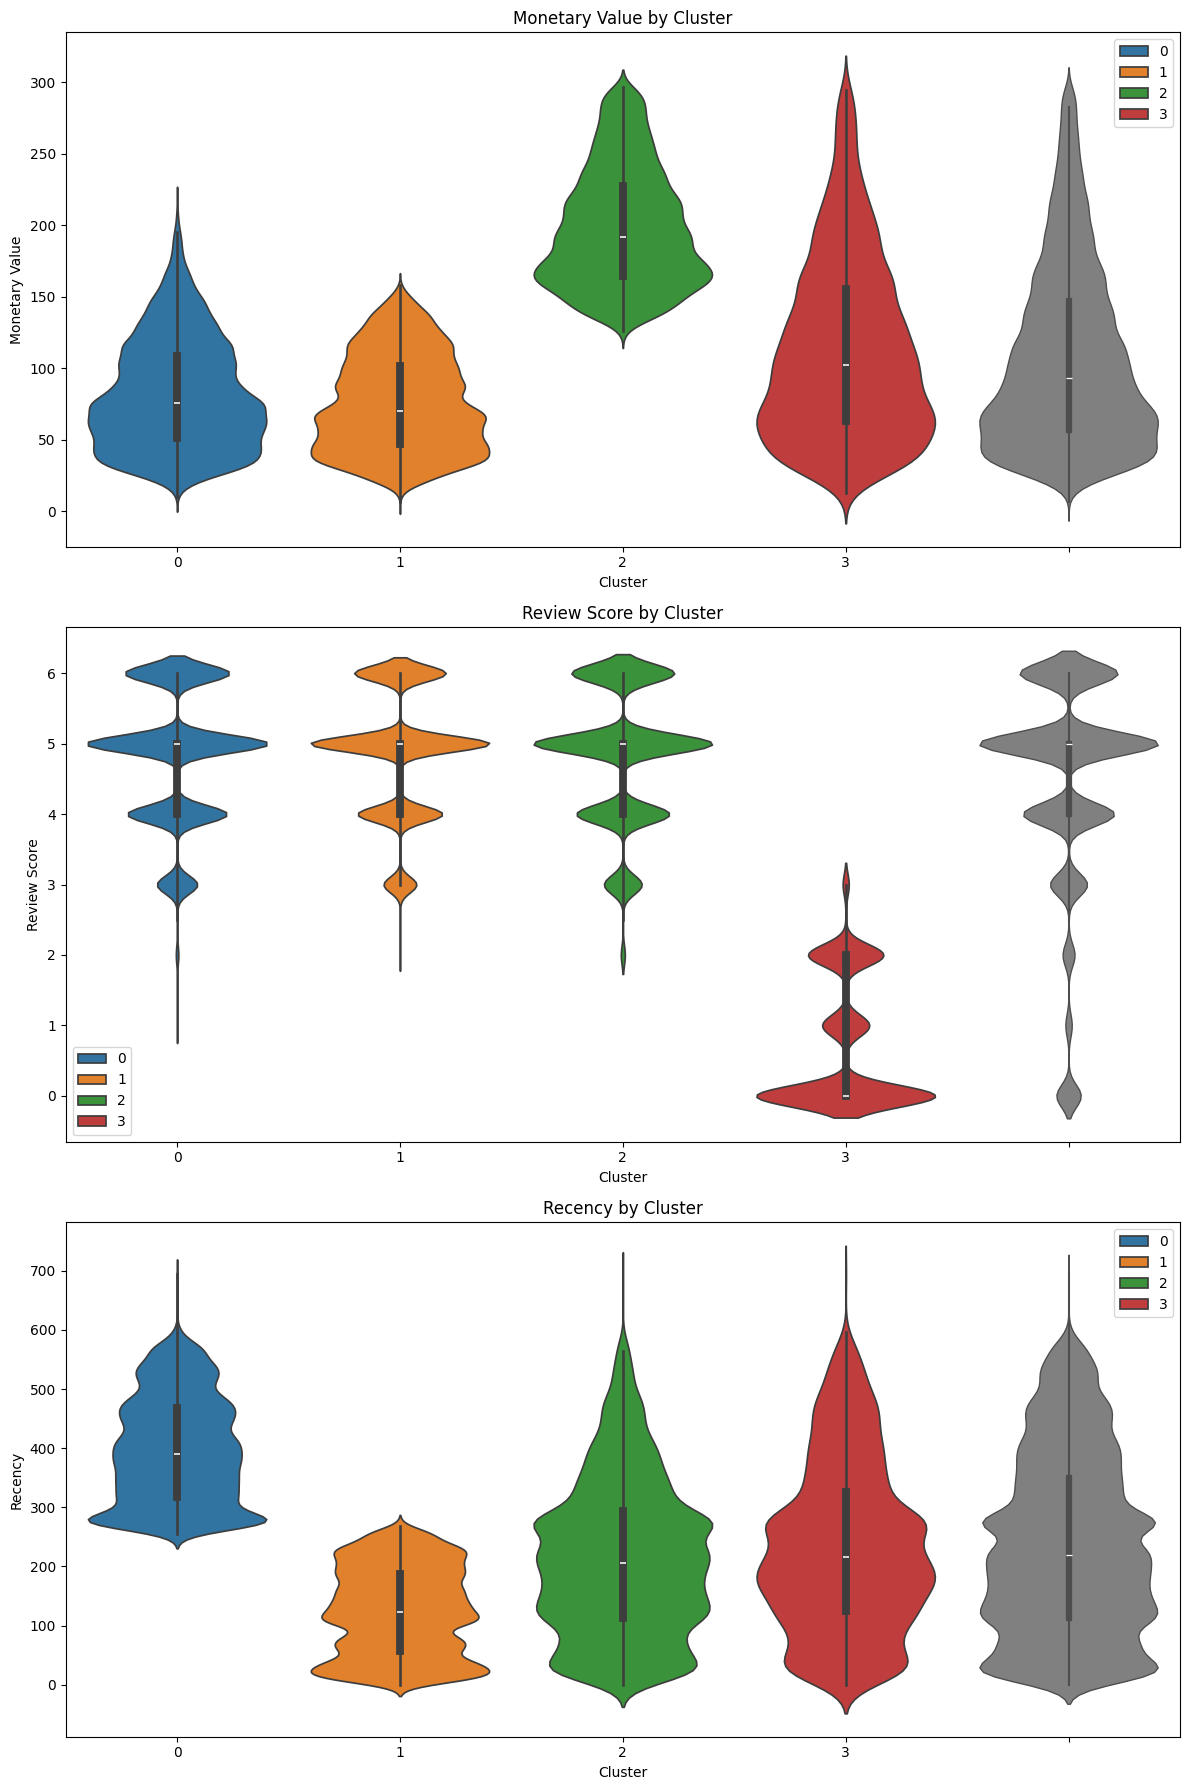

In [40]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['ReviewScore'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['ReviewScore'], color='gray', linewidth=1.0)
plt.title('Review Score by Cluster')
plt.ylabel('Review Score')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [41]:
monetary_outliers_df["Cluster"] = -1

outlier_clusters_df = pd.concat([monetary_outliers_df])
outlier_clusters_df

,order_id,MonetaryValue,Recency,ReviewScore,Cluster
26,0011d82c4b53e22e84023405fb467e57,315.33,224.0,4.0,-1
164,0078a358a14592b887eb140ef515f5ab,336.38,295.0,6.0,-1
199,0094d4660e323945f84f5c29eb348aae,309.40,216.0,5.0,-1
226,00a57dfbb049fbaae10763e2cf15f797,337.38,40.0,5.0,-1
276,00c00d5b36157595e21108ba1da2828f,312.92,351.0,1.0,-1
...,...,...,...,...,...
97613,ff4cdf9a24ffba79c88c81aeb858b4c7,303.86,384.0,5.0,-1
97745,ffb2c3a5bb149a2f860e5d057096201f,311.88,117.0,5.0,-1
97798,ffdc5e3279114c523a09296f8fd28331,317.79,565.0,4.0,-1
97804,ffde92ba447b33a47d1c04d203f10f41,304.70,278.0,5.0,-1


In [42]:
# cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
# full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
# feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

# fig, ax1 = plt.subplots(figsize=(12, 8))

# sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
# ax1.set_ylabel('Number of Customers', color='b')
# ax1.set_title('Cluster Distribution with Average Feature Values')

# ax2 = ax1.twinx()

# sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
# ax2.set_ylabel('Average Value', color='g')

# plt.show()